# Machine Learning
© Bledar Fazlija, 2021

- Linear regression
- Logistic regression
- Naive Bayes classifier
- K-nearest neighbors (KNN)
- Decision trees
- **Ensemble learning**
- Support Vector Machines (SVMs)
- Unsupervised learning

**This lecture in short**: In this lecture you learn how to combine several models and how that might lead to models with increased predictive performance. You will learn two tree-based and important methods *random forest* and *adaboost*.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

df_classifier = DecisionTreeClassifier(random_state=2)

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=2)

params_DT = {'criterion': ['entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,10,15,20],
             'min_samples_split': [2, 3]}

dtb_cv = GridSearchCV(estimator=df_classifier, 
                     #param_grid=params_DT, 
                     param_grid={"min_samples_split": range(2, 403, 20)},
                     cv=cv_method,
                     verbose=1, #output Messages
                     #refit=False,
                     refit="AUC",
                     return_train_score=True,
                     scoring=scoring) #'accuracy') #brauchen wir noch mehr Outputs?

dtb_cv.fit(x_binary, y_binary)
results = dtb_cv.cv_results_;

In [ ]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 150)
ax.set_ylim(0.5, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_min_samples_split"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

# Ensemble Learning
It is well known in the field of machine learning (also shown by the [no free lunch theorem](https://en.wikipedia.org/wiki/No_free_lunch_theorem)) that there is no single model that works best on all problems/datasets. Different models usually show different strengths and weaknesses. Ensemble learning is the attempt to build one model by combining several models. This often helps to tackle some of the problems that each single model has (like being a poor predictor, having high bias, high variance, etc.). 

## Lecture overview
- Bootstrap
- Bagging
- Random Forest
- AdaBoost


### Basic ideas

Instead of using only one model, how about using several models at the same time? Different models have different strengths and weaknesses. Can we take advantage of that? The following figure shows the overall idea of ensemble learning. 


<table><tr><td><img src='Ensemble.jpg' style="width: 550px;"></td></tr><table>
    
Out of single dataset we generate several datasets (often of approximately the same size; how is that possible? **Any ideas?**) und train a model for each. At the end we combine them to get a single prediction (do you have an idea of how you could do that? **Any ideas?**). 

Questions we want to answer are:

- How do we estimate performance of machine learning models?
- How do we combine several models (their results, respectively) to get a better result for a given problem?

- Can several weak predictors (models) be combined to give one strong predictor?

- Can we use several models to reduce high variance?

### Literature

- [1] Pattern Recgonition and Machine Learning, Bishop. 
- [2] The Elements of Statistical Learning 2nd Edition,  T. Hastie, R. Tibshirani, J. Friedman


### Applications
The methods described here are widely applied. Especially the two methods *random forest* and *adaboost* have become workhorses in industry and are widely used in research as well.





## Bootstrap

One way to test the accuracy of a statistical model (that we will also use for our machine learning models as well) is to generate out of an existing dataset several datasets and use them to train models and compare their results. We already encountered the so-called *$K$-fold cross-validation*, for which we splited the dataset in $K$ subsets, for which each plays the role of a validation set at some point in the process, while the others are training sets. 

One special property of cross-validation was that the validation set was *disjoint* from the train set at all instances. For the *bootstrap* method, we *get rid of this property*!

Consider a dataset $Z = \{z_1,...,z_N\}$. From this, generate a new data set $Z_b$ by drawing $N$ points at random from $Z$, *with replacement*. This leads to a set that might have repetitions, whereas some of the points from $Z$ are not in $Z_b$. This process can be repeated to generate $n$ different datasets of the same size.

### Illustration

The following figure illustrates the generation of $n$ bootstraps. 

<table><tr><td><img src='bootstrap.jpg' style="width: 750px;"></td></tr><table>


We can use these sets and test the variability of the performance in models on these datesets. 
    
As *test sets* we use the datapoints that were in the original dataset $Z$ but not in the respective $Z_i$. 
    
The performance of the model is *averaged* over all iterations (i.e. training on $Z_i$ and testing "Test set $i$")


**Example**: Consider the list $Z=[1,3,4,5,6]$. Two examples of bootstraps are $Z_1=[3,1,3,4,1]$ and $Z_2=[1,3,3,4,4]$.

**Exercise**: Consider the labeled dataset $X = \{(1,0), (2,1), (5,0), (6,0), (8,1), (9,1), (12,1), (18,0), (20,1)\}$. Generate a boostraps from $X$. 

**Solution**: One example of a bootstrap is $X_1 = [(1,0), (2,1), (5,0), (6,0), (2,1), (9,1), (2,1), (18,0), (5,0)].$

**Exercise**: Write a small program that generates, for given numbers $n$ and $k$, $k$ bootstraps out of the set $Z=\{1,2,..,n\}$. 

*Hint*: Write a function with arguments $n$ and $k$, returning the $k$ bootstraps. You may also set $k$ to a small number $<10$, if a general $k$ is too complicated.


## Bagging 

Bagging is short for bootstrap aggregating. So, the concept of bootstrap is used crucially. It is an ensemble meta-algorithm to improve the stability and accuracy of machine learning algorithms used for classification and regression. It reduces variance and helps to avoid overfitting. In the context of decision trees bagging is particularly efficient, however, the method can also be used for other models. 


**In short**: Bagging is...

... *used to combine prediction of different classification and regression models*.

... *used to reduce the variance of an estimated prediction function*.

... *efficient for high-variance, low-bias procedures (e.g. decision trees)*.

... *helps to avoid to overfitting*. 

<br>

The following figure illustrates the way bagging works. 


<table><tr><td><img src='bagging_2.jpg' style="width: 750px;"></td></tr><table>


<br>

### Formalism

For a given set $Z$, consider $B$ bootstraps $Z_1, ...., Z_B$ (generated as described above). Use each set $Z_i$ to train a model $y_i$, for $i=1, ..., B$.

The *committee* prediction in the *regression* case (i.e. prediction from all the trained models) is given by:

<h4>
$$y_{com}(x) = \frac{1}{B}\sum_{m=1}^B y_m(x).$$
</h4>

This way of combining models is called *bootstrap aggregating*, also called *bagging*.  
    
**Note** that we have weighted all $y_m$'s equally above. However, this is not necessary and one can give different weights to different $y_m$'s.

<h4>
$$y_{com}(x) = \frac{1}{B}\sum_{m=1}^B w_my_m(x).$$
</h4> 

This weighting could be seen as higher weights being representing *better* or *more important* models, whereas lower weight means that that model plays less of a role, which we would call *weaker* model. 

Here fit the same regression tree many times to bootstraps generated out of the training data. Then, similarly to above, take the average of the results.





### Exercise (!). 


Given an example of bagging using *Decision Trees* or *KNN* for classification and regression. For this, use one of the datasets used so far. Compare the results with the performance of the *base model*.  

*Hint*: Use the two packages:
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html 
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html




**Note**: For some kind of models (e.g. decision trees) bagging variants are widely used and there are implementations. 

## From bagging to *random forest*

Random forest is essentially bagging with *one crucial difference*: At each split in the learning process, only a random **subset** of the whole set of features is selected. This generates a set of de-correlated trees. It is one of the most widely used class of machine learning models. It is among the workhorses in both industry and research.



### Random forest algorithm

   - Can be used for classification and regression
   - Handles well for different levels of scales of data
       - metric and categorial data?

We will explain the random forest algorithm here. Assume we consider a training set $X$ consisting of $N$ elements. 

<hr>

**Algorithm (see [2] for details)**

1. For b = 1 to B do the following:

    (a) Generate a bootstrap $X_b$ of size $N$ from the training data.
    
    (b) Create a tree $T_b$ to $X_b$, by recursively repeating for each terminal node of the tree, until the minimum node size $n_{min}$ is reached.
        i. Select m variables (features) at random from the p variables (features). 
        ii. Pick the best variable/split-point among the m.
        iii. Split the node into two daughter nodes.
        
 
2. Output the ensemble of trees $\{T_b\}_{b=1}^B$.



Next, we explain how to make a prediction at a **new point** $x$ for regression and classification tasks.  

For a _regression_ task we predict by: 

<h4>
 
$$F_{random forest}(x)=\frac{1}{B} \sum_{b=1}^B T_b(x).$$

</h4>


For _classification_ we proceed as follows. Let $C_b(x)$ be the class prediction of the $b$th random-forest tree.
The final prediction is then given 

<h4>
    
$$C_{random forest}(x) = \text{majority vote among } \{C_1(x),C_2(x),...,C_B(x)\}$$

</h4>

Put differently, $x$ is assigned to the class which has the most votes counted over all classifications over the different trees.  

<hr>

**Todo**:
- Add figure for random forest.

### Measuring Performance

For every bootstrap there will be datapoints that were in the original training set but not in the bootstrap. In makes sense to consider the performance on such points, which are called **out-of-bag samples**.




### Implementation of random forest 

First let us generate a synthetic dataset that we will use as a first example, to test the different models. 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Synthetic data example

The following is a function that uses the `random.randn()` function of numpy to generate a set of data. 

In [28]:
def random_data(n):
    X = np.random.normal(size=(n,2))+np.random.randn(1)
    Y = np.random.choice([-1,1], size=n)
    for i in range(len(Y)):
        X[i] += Y[i]*np.array([-1,0.9])
    return X,Y

### Split data

Use the above function to generate a dataset of $500$ datapoints and split data into a training set and a test set.

In [29]:
X,Y = random_data(500)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify=Y, random_state=42)

Let us consider the distribution of the two classes that we want to predict. 

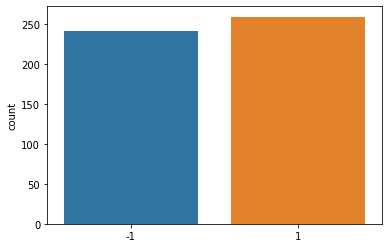

In [30]:
import seaborn as sns

sns.countplot(Y)    

**Exercise**: Write a code that counts the number of the different classes. 

Let us plot the data in a scatterplot.



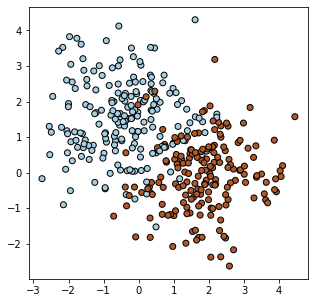

In [31]:
plt.figure(figsize=(5,5))
plt.scatter(X_train[:,0], X_train[:,1],c=Y_train, cmap='Paired_r', edgecolors='k')

### Import the random forest classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

### Define and train a random forest classifier

Note the setting concerning the hyperparameter `max_depth`. We will discuss about its effect in more detail below. 

In [36]:
rf = RandomForestClassifier(max_depth=15, random_state=0)

In [37]:
#Fit random forest classification model to training data
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Compute the predictions of the trained model `rf` on the test set $X_{test}$.

In [38]:
y_pred = rf.predict(X_test)

**Exercise**

Plot the predicted and the true labels. Write a small program that compares them and says whether the results are good or not (for this define a threshold of what good or bad is for you; you may also choose more categories like bad, middle, good results).

*Hint*: You may find code in prior notebooks, for the first part of the exercise. 

### Import methods for confusion matrix and metrics

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print("\n \n Classification report \n\n", metrics.classification_report(Y_test, y_pred))


 
 Classification report 

               precision    recall  f1-score   support

          -1       0.95      0.90      0.92        60
           1       0.91      0.95      0.93        65

    accuracy                           0.93       125
   macro avg       0.93      0.93      0.93       125
weighted avg       0.93      0.93      0.93       125



In [15]:
cm = confusion_matrix(Y_test, y_pred)
print("\n \n The confusion matrix is given by: \n \n", cm)


 
 The confusion matrix is given by: 
 
 [[53  6]
 [ 7 59]]


### Random forest feature importance  

One important aspect of random forest is its ability to list the order of predictive power of the given features (=variables). For example, if one likes to predict the income of a person and is given the features *age, years spent in school, income of parents, number of siblings*; feature importance can determine which of those are most useful to predict income (for a random forest model) and order them accordingly. 


**Remark**: Random forest feature importance can also solely be used to find out which features are to be used in a model, even when the underlying model is not related to trees or random forest. This falls into the area of [**feature selection**](https://en.wikipedia.org/wiki/Feature_selection), which is an art in itself and usually a crucial aspect in many practical applications. In the above example you might find out, for instance, that it is most useful to use just the features *age, years spent in school and income of parents* and neglect the others as they are not beneficial. 

####  Example of feature importance

Let us compute the feature importance for the two features ($x$- and $y$-coordinates) of the above synthetically generated dataset.  

In [41]:
print(rf.feature_importances_)

[0.59697223 0.40302777]


**Exercise**

- Conduct hyperparameter tuning for the parameters 'max_depth' and 'random_state' by check for a list of integers of your choice for each of the two parameters. 

- Plot the scores for each of the parameters

*Hint*: Consider the example in the notebook on decision trees. 


### Further example with random forest

We will consider the digits dataset that contains handwritten digits. The relevant task is classifying the handwritten task and thus predicting numbers $0, ..., 9$.

In [42]:
import pandas as pd

#Load digits dataset
from sklearn.datasets import load_digits

digits = load_digits()

In [43]:
digits.data.shape

(1797, 64)

Let us look at some examples of handwritten digits among the numbers $0,...,9$.

<Figure size 432x288 with 0 Axes>

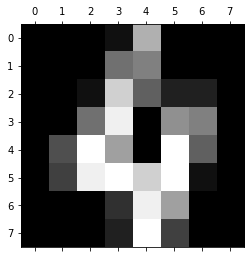

<Figure size 432x288 with 0 Axes>

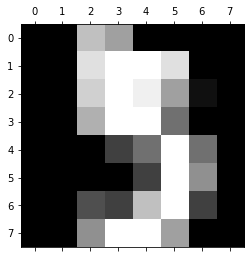

<Figure size 432x288 with 0 Axes>

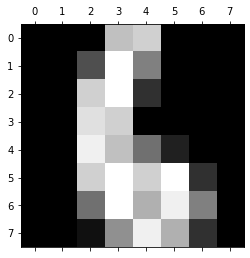

In [44]:
import matplotlib.pyplot as plt 

for i in range(4,7):
    plt.gray() 
    plt.matshow(digits.images[i]) 
    plt.show() 

**Note** that each of these figures has $8\cdot 8=64$ squares. 

So, in the dataframe below, each row represents one handwritten number. 

In [45]:
# Transform the numpy array into a dataframe
df = pd.DataFrame(digits.data)

#labels of each of the pictures
df_targets = pd.DataFrame(digits.target)

In [46]:
df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


Let us build a random forest classification model to predict the digits corresponding to the given pictures. 

Above we have already used _from sklearn.ensemble import RandomForestClassifier_.

In [47]:
df_targets

,0
0,0
1,1
2,2
3,3
4,4
...,...
1792,9
1793,0
1794,8
1795,9


### Split the data 

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(df,df_targets, random_state=42)

### Define and train a random forest model 

In [61]:
rf = RandomForestClassifier(max_depth=10, random_state=0)

**Exercise** (!): Define decision tree model (with same depth) and run through to compare the two results (i.e. random forest vs. simple decision tree 🌳). Try increasing model complexity and see what happens.

*Hint*: With growing model complexity you should notice the disadvantage of simple decision trees due to overfitting (high variance). 

In [62]:
rf.fit(X_train, Y_train)

/Users/bf/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Compute the predictions on the test set

In [63]:
# Now predict the value of the digit on the second half:
predicted = rf.predict(X_test)

In [64]:
type(predicted)

numpy.ndarray

In [65]:
predicted_results = pd.DataFrame(predicted)

predicted_results

,0
0,6
1,9
2,3
3,7
4,2
...,...
445,3
446,6
447,2
448,6


In [66]:
# Import relevant packages
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics

If you do not know what these packages are used for, read the corresponding sklearn page. 

In [67]:
accuracy_score(Y_test, predicted_results)

0.9733333333333334

In [68]:
precision_score(Y_test, predicted_results, average='macro')

0.973995009412211

In [69]:
recall_score(Y_test, predicted_results, average='macro')

0.9736717777918722

**Exercise**

In [70]:
# Print the confusion matrix
print(metrics.confusion_matrix(Y_test, predicted_results))

[[42  0  0  0  1  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0]
 [ 0  0  0 43  0  1  0  0  2  0]
 [ 0  0  0  0 55  0  0  0  0  0]
 [ 0  0  0  0  0 57  1  0  0  1]
 [ 0  0  0  0  0  1 44  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  1]
 [ 0  2  0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  1  0  1  0 46]]


**Exercise** (With this exercise you will learn to interpret the results of a confusion matrix)

- Looking at this confusion matrix, what can be said about the best performance measure? 

- Which class is being predicted particularly good/bad? Which numbers does the algorithm mistaken for which ones most often? 

- Explain in words what this confusion matrix says about the classification of the class 0 (=number 0) and class 10 (=number 9). Give a possible explanation in terms of why a human might make similar mistakes. 

- How would you define a notion of accuracy given such a confusion matrix? We have seen the definition of accuracy for a confusion matrix for binary classification in the context of *logistic regression*. Compare your results with that of the accuracy given below in the *classification report*.


**Exercise** (!): Compare random forest with bagging for the handwritten digits. 

In [71]:
# Print the precision and recall, among other metrics
print(metrics.classification_report(Y_test, predicted_results, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.977     0.988        43
           1      0.949     1.000     0.974        37
           2      1.000     1.000     1.000        38
           3      1.000     0.935     0.966        46
           4      0.982     1.000     0.991        55
           5      0.950     0.966     0.958        59
           6      0.978     0.978     0.978        45
           7      0.976     0.976     0.976        41
           8      0.947     0.947     0.947        38
           9      0.958     0.958     0.958        48

    accuracy                          0.973       450
   macro avg      0.974     0.974     0.974       450
weighted avg      0.974     0.973     0.973       450



## Boosting
... *combining many weak learners to get one strong one*.

... *committee of weak learners, changing over time, members cast a weighted vote*.

**Optional reading task**: See [2], page 337 onwards, for more details on boosting. 

In contrast to bagging, for boosting
- base classifiers are trained in sequence
- each base classifier is trained using a weighted form of the dataset

Let us introduce the notions needed to understand the working of the concept of boosting. We assume from now on that we deal with a *binary classification* task with two classes labeled $-1$ and $+1$.  

**Definition (error rate)**: The *error rate* of a predictor (=classifier) $G$ on a given training set $\{(x_i, y_i)\}_{i=1}^N$ is given by: 

<h4>
$$\overline{err} = \frac{1}{N}\sum_{i=1}^N I(y_i \not = G(x_i)), $$
</h4>

where $I$ is the indicator function, which is equal to $1$ when the argument is true and $0$ otherwise. 

**Example**: $I(1\not=2) = 1$ and $I(1\not=1) = 0$. 


**Example**: Let us compute an example of an error rate. Assume you are given the datapoints $\{(x_1,1), (x_2,1), (x_3,-1), (x_4,1)\}$ and that the predictor $G$ gives the following results: $G(x_1)=-1, G(x_2)=1, G(x_3)=-1, G(x_4)=1$. The error rate is computed as $\overline{err} = \frac{1}{4}(1+0+0+0) = \frac{1}{4}$. 

Thus, the given predictor $G$ has an error rate of 25\% on the given training set.




**General definition (Indicator function)**: For a subset $A$ of a set $X$, the indicator function $I_A:X\rightarrow \{0,1\}$ is given by

$
I_A (x) = 
 \begin{cases} 
      1 & x\in A \\
      0 & x\not\in A.  
   \end{cases}
$

Another notion needed in the present context is that of *weak classifier*. 

**Definition (weak classifier, [2], page 337)**: A _weak classifier_ is one whose error rate is only slightly better than random guessing. This means that the error rate is just slightly below $0.5$, in the context of binary classification. 

The following schematic depiction ([2], page 338) explains the way that boosting works. 

<br>

<table><tr><td><img src='boosting.png' style="width: 550px;"></td></tr><table>
    
<br>
    
Note: The final classifier just asks for the sign (whether positive or negative) as this discussion assumed the underlying problem to be a binary classification problem with classes $-1$ and $+1$. Thus, majority vote is equivalent to asking whether the weighted sum of all predictions is positive or negative. 

### Weighting of the training set

The question remains: *How does the weighting of the training sets work*? 

At each boosting step, weights $w_1, ..., w_N$ are multiplied to the training data points $\{(x_i,y_i)\}_{i=1}^N$. 

At the initial step, all weights are chosen equal to be $w_i = 1/N$.

For the steps $m=2, ..., M$: Weights are modified individually, and the classification algorithm is used on the new dataset. Weights of points that were misclassified in the prior step (i.e. for $G_{m-1}$) are increased, while, on the other hand, weights of points correctly classified by $G_{m-1}$ are decreased. 


## AdaBoost

The precise way in which the weights are modified is given in the case of **Adaboost** in the following outline of the algorithm.

<br>
Source: [2], page 339. 
<table><tr><td><img src='adaboost.png' style="width: 650px;"></td></tr><table>




### Remark

One can show that the above algorithm is equivalent to an optimization problem called *Forward Stagewise Additive Modeling* that uses an exponential loss function. For further reading see [2], page 342.


## Implementation of Adaboost

Let us consider an the example with synthetic data and compare the results of Adaboost and simple decision trees. 


In [33]:
from sklearn.ensemble import AdaBoostClassifier

### Define and train a model

In [34]:
# Define AdaBoost model
clf = AdaBoostClassifier(n_estimators=100, random_state=0)

In [35]:
# Train model on the training set
clf.fit(X_train, Y_train)

/Users/bf/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

### Compute the feature importances

Note that this uses the *random forest feature importance* introduced above. We could use this information to select the features that help in prediction. 

In [36]:
clf.feature_importances_

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.49, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

**Exercise**: Interpret these results. 

In [37]:
clf.predict(df.values)

array([0, 8, 8, ..., 8, 8, 8])

In [38]:
print("Accuracy on the training set: {:.3f}".format(clf.score(X_train, Y_train)))
print("Accuracy on the test set: {:.3f}".format(clf.score(X_test, Y_test)))

Accuracy on the training set: 0.347
Accuracy on the test set: 0.336


### Compare above results with simple decision trees

In [39]:
from sklearn.tree import DecisionTreeClassifier

In [40]:
tree = DecisionTreeClassifier(max_depth=3, random_state=2)

In [41]:
tree.fit(X_train,Y_train);

In [42]:
print("Accuracy on the training set: {:.3f}".format(tree.score(X_train, Y_train)))
print("Accuracy on the test set: {:.3f}".format(tree.score(X_test, Y_test)))

Accuracy on the training set: 0.411
Accuracy on the test set: 0.380


**Exercise**: Repeat the experiments done with decision trees on the iris dataset with Adaboost and compare the results. 

### Exercise: Apply what you have learned!

- Invest some time to do experiments with the ensemble learning methods that you have learned in this notebook. Consider different experiments that we conducted with simple decision trees and other methods and compare them with random forest and adaboost. 

- Try to "see" the decrease in variance for decision trees when using random forest. Ask yourself: what happens with the bias as we use random forest instead of simple decision trees? 

- Discuss what tradeoff you would like to see between model complexity and model performance for decision trees and in which cases you would like or abstain from using random forest and adaboost. 

- Using the results from the exercises on bagging for KNN: Compare them with bagging for decision trees and random forest. You should note that bagging is particularly powerful when used with decision trees. Why could that be? Does KNN also have high variance? 

### Tasks
- Go through the notebook step by step
- Solve exercises or go through the solutions

### Optional exercise

Conduct feature selection for problems that we have considered earlier using random forest feature importance. See if you can increase the predictive performance of whatever model you are using by choosing only the best features. 

### Advanced reading

Although methods like random forest and adaboost are very powerful, it is not entirely clear why this is the case. The following paper makes an attempt towards explaining the success. 

https://dl.acm.org/doi/pdf/10.5555/3122009.3153004